# L1 - ImageNet pretrained ResNets with STONEFLY9 dataset<br><br>Single image predictions

In this notebook several single prediction APIs for the fastai library are shown.<br><br>
<font color='blue'>**The best approach without a full databunch setup is variant D!**</font><br>
Variant A uses a full databunch and learner setup. Variant B and C are not working.<br><br>
The base notebook can be found here: https://github.com/MicPie/fastai_course_v3/blob/master/L1-stonefly.ipynb

## Notebook setup

In [1]:
# notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai library
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
# set path to data directory
path = Path('/home/paperspace/fastai/data/stonefly')

In [4]:
size = 224 # image size used for training (Note: is only applied when ds_tfms are set)
bs = 64 # batchsize for training

### Dataframe setup

In [5]:
# read in text file with a list of all the files
df = pd.read_csv(path/'files.txt', sep=' ', header=None, names=['imgurl'])

In [6]:
# test of string manipulation to get the data class
#('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125.jpg').split('/', 6)[-1] # split only 6 times

In [7]:
# define string manipulation lambda function to get path after the defined path variable
f = lambda x: x.split('/', 6)[-1]
df['imgurl'] = df['imgurl'].apply(f)

In [8]:
# test of string manipulation to get the data class
#('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125.jpg').split('/')[-3]

In [9]:
# define string manipulation lambda function to get data class
f = lambda x: x.split('/')[-3]
df['class'] = df['imgurl'].apply(f)

## Single image prediction with ResNet34

In [10]:
# setup classes list
classes = ['cal', 'dor', 'hes', 'iso', 'mos', 'pte', 'swe', 'yor', 'zap']#; classes

### A - Setup full learner model

In [11]:
!gpustat --no-header

[0] Quadro P4000     | 30'C,   0 % |    10 /  8119 MB |


In [12]:
data_A = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=size, bs=bs)

In [13]:
# normalize data with the imagent_stats
data_A.normalize(imagenet_stats);

In [14]:
learn_A = create_cnn(data_A, models.resnet34, metrics=accuracy)

In [15]:
learn_A.load('stonefly_resnet34_stage_2')

In [16]:
learn_A.model.eval();

In [17]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   8 % |   701 /  8119 MB | paperspace(691M)


### B - Setup model with empty ds

In [18]:
# From https://forums.fast.ai/t/how-to-get-an-empty-convlearner-for-single-image-prediction/28245/16

In [19]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   0 % |   701 /  8119 MB | paperspace(691M)


In [20]:
# creat empty dataset: ImageClassificationDataset(fns, labels, classes)
# fns & labels are just a dummy vaue, classes list is handed over for the prediction
ds_B = ImageClassificationDataset([classes[0]], [classes[0]], classes)

In [21]:
data_B = ImageDataBunch.create(ds_B, ds_B, str(path/'tmp'), ds_tfms=get_transforms(), size=size)

In [22]:
learn_B = create_cnn(data_B, models.resnet34, metrics=accuracy)

In [23]:
learn_B.model.eval();

In [24]:
learn_B.load(path/'models/stonefly_resnet34_stage_2')

In [25]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,  11 % |   803 /  8119 MB | paperspace(793M)


### C - Setup model without learner

In [26]:
# From https://forums.fast.ai/t/using-our-trained-model-against-a-specific-image/28262

In [27]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   0 % |   803 /  8119 MB | paperspace(793M)


In [28]:
# show original model structure
#models.resnet34()

In [29]:
# create backbone NN from ResNet34 model and cut off the last two layers
backbone = create_body(models.resnet34(), -2)#, backbone

In [30]:
# show backbone
#backbone

In [31]:
# create custom head for backbone with needed number of output features
head = create_head(num_features_model(backbone)*2, len(classes))#, head

In [32]:
# show head structure
#head

In [33]:
# stick backbone and head together
m_C = nn.Sequential(backbone, head)

In [34]:
# load save weights from training the ResNet34 (see above)
m_C.load_state_dict(torch.load(path/'models/stonefly_resnet34_stage_2.pth'))

In [35]:
# put model into evaluation mode and suppress output
m_C.eval();

In [36]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   0 % |   803 /  8119 MB | paperspace(793M)


### D - New setup model without learner

In [37]:
# https://forums.fast.ai/t/how-to-get-an-empty-convlearner-for-single-image-prediction/28245/56?u=micpie
# https://github.com/fastai/fastai_docs/blob/master/dev_nb/104c_single_image_pred.ipynb

In [38]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   0 % |   803 /  8119 MB | paperspace(793M)


In [39]:
data_D = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=size).normalize(imagenet_stats)

In [40]:
learn_D = create_cnn(data_D, models.resnet34, metrics=accuracy)

In [41]:
learn_D.load(path/'models/stonefly_resnet34_stage_2')

In [42]:
!gpustat --no-header

[0] Quadro P4000     | 31'C,   4 % |   905 /  8119 MB | paperspace(895M)


### Load image for prediction

In [43]:
# set image number for prediction
img_num = 3036

In [44]:
img_path = path/df.iloc[img_num,0]; img_path

PosixPath('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/yor/set1/Yor_103-specimen-i004-s125.jpg')

In [45]:
# show image with matplotlib
#plt.imshow(plt.imread(img_path))

In [46]:
# open image
img = open_image(img_path)#; img

#### Image transformation, visualization, and shape check (optional)

In [47]:
# setup transformations
train_tfms, valid_tfms = get_transforms()

In [48]:
# apply transformations
img_tfm = apply_tfms(valid_tfms.append(normalize_funcs(*imagenet_stats)), img, size=size)

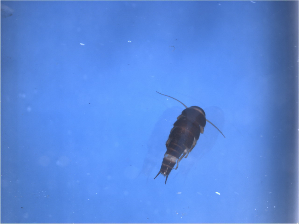

In [49]:
# show transformed image
img_tfm

In [50]:
# check shapes
img_tfm.data.shape#, img_tfm.data

torch.Size([3, 224, 299])

In [51]:
# unsequeeze to add dimension for batches used in training
img_tfm.data.unsqueeze(0).shape #, img_tfm.data.unsqueeze(0)

torch.Size([1, 3, 224, 299])

### A - Predict with full learner model

In [52]:
preds_A = learn_A.predict(img); preds_A

('yor',
 tensor(7),
 tensor([7.6139e-12, 6.0341e-13, 1.9533e-09, 5.7258e-10, 5.1795e-11, 1.4329e-10,
         1.6058e-10, 1.0000e+00, 1.5328e-09]))

In [53]:
# show original label
df.iloc[img_num,1]

'yor'

<font color='green'>Correct prediction!

### B - Predict with model with empty ds

In [54]:
preds_B = learn_B.predict(img); preds_B

('iso',
 tensor(3),
 tensor([7.7185e-09, 1.0376e-07, 3.9306e-03, 9.9289e-01, 1.1806e-07, 4.4313e-09,
         1.9186e-04, 1.8847e-05, 2.9677e-03]))

<font color='red'>Wrong prediction!

In [55]:
# show original label
df.iloc[img_num,1]

'yor'

### C - Predict with model without learner

In [56]:
log_preds_C = m_C(img_tfm.data.unsqueeze(0)); log_preds_C

tensor([[-8.2196, -6.0990,  5.7681, 11.8358, -5.6677, -9.4471,  0.1673, -0.4162,
          4.7292]], grad_fn=<ThAddmmBackward>)

In [57]:
# argmax of log_preds
torch.argmax(log_preds_C)

tensor(3)

In [58]:
# show predicted label
classes[torch.argmax(log_preds_C)]

'iso'

<font color='red'>Wrong prediction!

In [59]:
# show original label
df.iloc[img_num,1]

'yor'

### D - New setup model without learner

In [60]:
preds_D = learn_D.predict(img); preds_D

('yor',
 tensor(7),
 tensor([2.5390e-03, 2.0122e-04, 6.5139e-01, 1.9094e-01, 1.7272e-02, 4.7782e-02,
         5.3549e-02, 3.3347e+08, 5.1116e-01]))

In [61]:
# show original label
df.iloc[img_num,1]

'yor'

<font color='green'>Correct prediction!